This notebook trains EB estimators on the Opportunity Atlas dataset (following the motivating example in [Jiafeng Chen's](https://github.com/jiafengkevinchen/close-replication/) "Empirical Bayes When Estimation Precision Predicts Parameters"). After training the EB estimators, this notebook
1. Saves the shrinkage rules as a csv.
2. Obtains the priors of SURE-PM and NPMLE.


# Set up

In [1]:
import sys  
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd 
import numpy as np
import torch as tr

# Our EB methods
from train import train_no_covariates as train_no_covariates
from train import train_npmle as train_npmle
from train import train_covariates as train_covariates
from train import train_sure_ls as train_sure_ls


simulate_data.py: device = cpu


In [2]:
def load_data_for_outcome(est_var, input_dir="atlas_data/oa_data_used.feather"):
    """
    Load the processed data for a given outcome variable
    Filter out missing values and values where the standard error is too large
    """
    df = pd.read_feather(input_dir)
    se_var = est_var + "_se"
    subset = df[[est_var, se_var, "czname", "state", "county", "tract"] + clean_covariates].dropna()
    thresh = subset[se_var].quantile(0.995)
    subset = subset.loc[subset[se_var] <= thresh].reset_index(drop=True)

    return subset

clean_covariates = ['par_rank_pooled_pooled_mean',
 'par_rank_black_pooled_mean',
 'poor_share2010',
 'share_black2010',
 'hhinc_mean2000',
 'ln_wage_growth_hs_grad',
 'frac_coll_plus2010',
 'log_kid_black_pooled_blw_p50_n',
 'log_kid_pooled_pooled_blw_p50_n']
est_var = "kfr_top20_black_pooled_p25"

df = load_data_for_outcome(est_var)
estimates = df[est_var].values
sigma_np = df[est_var + "_se"].values

n = df.shape[0]
B = 100
device="cpu"
Z = tr.tensor(estimates).to(device)
X_sigma = tr.tensor(sigma_np.reshape(n, 1)).to(device)

use_location = False
use_scale = True
set_seed_thing = 15 # for debugging, not for simulation

zeros_for_theta = np.zeros((n,))


In [3]:
print(f"The mean of the standard errors is {np.mean(sigma_np**2)}.")

The mean of the standard errors is 0.0029098331424100635.


# Only sigma for X

## Train

In [4]:
# NPMLE
prob_NPMLE, loss_NPMLE, score_NPMLE, theta_hat_NPMLE, two_norm_difference_NPMLE, pi_hat_NPMLE = train_npmle(n, B, Z, zeros_for_theta, X_sigma)

In [5]:
# SURE-PM
model_pm, losses_pm, scores_pm, theta_hats_pm, fake_two_norm_differences_pm = train_no_covariates(n, B, Z, zeros_for_theta, X_sigma, use_location=use_location, use_scale = use_scale)

In [ ]:
# SURE-THING 
model_thing, feature_representation, losses_SURE_thing, losses_NLL_thing, scores_thing, theta_hats_thing, fake_two_norm_differences_thing = train_covariates(X_sigma, Z, zeros_for_theta, use_location = use_location, use_scale = use_scale,
                                                                                                                                                             hidden_sizes=(8,8), set_seed=set_seed_thing)


In [ ]:
# SURE-LS 
model_ls, feature_representation_ls, losses_ls, scores_ls, theta_hats_ls, fake_two_norm_differences_ls = train_sure_ls(X_sigma, Z, zeros_for_theta, objective="SURE", set_seed = set_seed_thing, d=2)

# Save shrinkage results for plotting in R

In [ ]:
theta_hat_dict = {'NPMLE': theta_hat_NPMLE,
                  'SURE-PM': theta_hats_pm[-1,:],
                  'SURE-THING': theta_hats_thing[-1,:],
                  'SURE-LS': theta_hats_ls[-1,:],
                  'Z (MLE)': df['kfr_top20_black_pooled_p25'].values,
                  'log-sigma': np.log10(df['kfr_top20_black_pooled_p25_se'].values)}

In [ ]:
pd.DataFrame(theta_hat_dict).to_csv("atlas_results/shrinkage_rule.csv")

# Get prior on Atlas dataset

In [6]:
pi_hat_npmle = pi_hat_NPMLE

theta_grid_npmle = np.linspace(max(Z).item(), min(Z).item(), B)

theta_grid_pm, pi_hat_pm = model_pm.get_theta_grid_and_pi(n, B)
theta_grid_pm = theta_grid_pm[0,]
pi_hat_pm = pi_hat_pm[0,]

In [7]:
print(f"NPMLE pi hat: {pi_hat_npmle}")
print(f"NPMLE theta grid: {tr.tensor(theta_grid_npmle)}")

NPMLE pi hat: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.9099e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.4995e-04, 1.8166e-09, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2358e-03, 0.0000e+00, 2.8937e-04, 1.1193e-01, 1.5913e-01,
        2.1244e-01, 2.0883e-01, 1.4932e-08, 1.2695e-01, 7.7585e-02, 5.7724e-02,
        3.7040e-10, 2.4492e-10, 2.8456e-02, 1.1694e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.3483e-03, 7.2037e-10, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000

In [8]:
print(f"SURE-PM pi hat: {pi_hat_pm}")
print(f"SURE-PM theta grid: {theta_grid_pm}")

SURE-PM pi hat: tensor([4.2038e-05, 7.2076e-05, 1.6573e-04, 3.2345e-04, 1.5166e-04, 5.6359e-05,
        2.0210e-05, 6.6435e-05, 1.7774e-04, 1.6753e-04, 1.4053e-04, 1.9507e-04,
        2.6089e-04, 2.9923e-04, 3.4886e-04, 4.3542e-04, 5.5036e-04, 6.6524e-04,
        7.4505e-04, 7.8211e-04, 7.9154e-04, 7.9376e-04, 8.6032e-04, 1.0423e-03,
        1.2671e-03, 1.4847e-03, 1.7183e-03, 1.9070e-03, 2.0200e-03, 2.2079e-03,
        2.6337e-03, 3.1373e-03, 3.3164e-03, 3.1520e-03, 3.1325e-03, 3.6482e-03,
        4.7467e-03, 6.3289e-03, 8.1328e-03, 9.6056e-03, 1.0194e-02, 9.9220e-03,
        9.3005e-03, 8.7439e-03, 8.3046e-03, 7.7384e-03, 6.7941e-03, 5.7958e-03,
        6.2386e-03, 1.0190e-02, 2.1387e-02, 4.5698e-02, 4.9681e-02, 2.6404e-02,
        1.3398e-02, 7.4874e-03, 3.9924e-03, 1.7042e-03, 2.4928e-03, 3.8033e-03,
        5.4037e-03, 7.4331e-03, 1.0052e-02, 1.3460e-02, 1.7888e-02, 2.3557e-02,
        3.0559e-02, 3.8619e-02, 4.6782e-02, 5.3322e-02, 5.6370e-02, 5.5103e-02,
        5.0323e-02, 4.37

In [9]:
import matplotlib.pyplot as plt

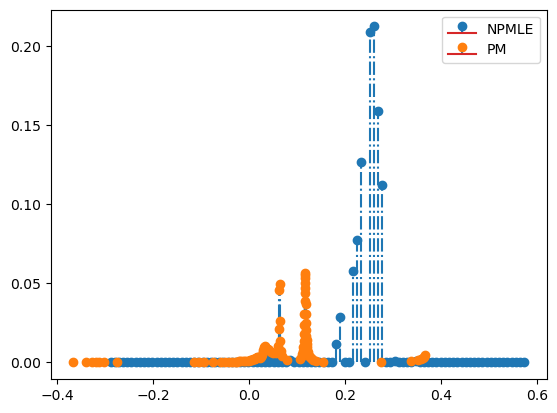

In [15]:
markerline_npmle, stemlines_npmle, baseline_npmle = plt.stem(theta_grid_npmle, pi_hat_npmle, '-.', label="NPMLE")
markerline_pm, stemlines_pm, baseline_pm = plt.stem(theta_grid_pm.detach().numpy(), pi_hat_pm.detach().numpy(), '-.', label="PM")

baseline_npmle.remove()
baseline_pm.remove()

plt.legend()
plt.show()

# Investigating scores for NPMLE and SURE-PM

In [9]:
import matplotlib.pyplot as plt


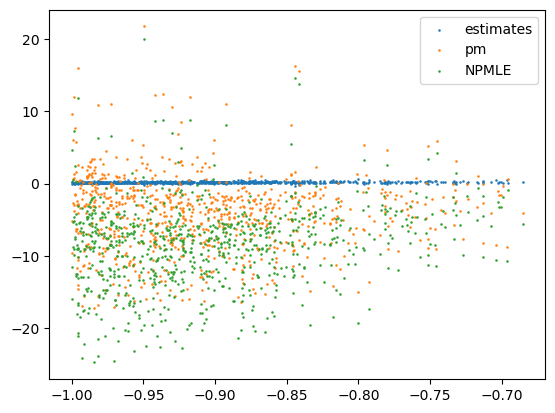

In [ ]:
plt.scatter(np.log10(sigma_np)[np.log10(sigma_np) > -1], estimates[np.log10(sigma_np) > -1], label="estimates", s = 0.8, alpha=0.9)

plt.scatter(np.log10(sigma_np)[np.log10(sigma_np) > -1],scores_pm[-1,:][np.log10(sigma_np) > -1], label="pm", s = 0.8, alpha=0.9)
plt.scatter(np.log10(sigma_np)[np.log10(sigma_np) > -1],score_NPMLE[np.log10(sigma_np) > -1], label="NPMLE", s = 0.8, alpha=0.9)


plt.legend()
plt.show()

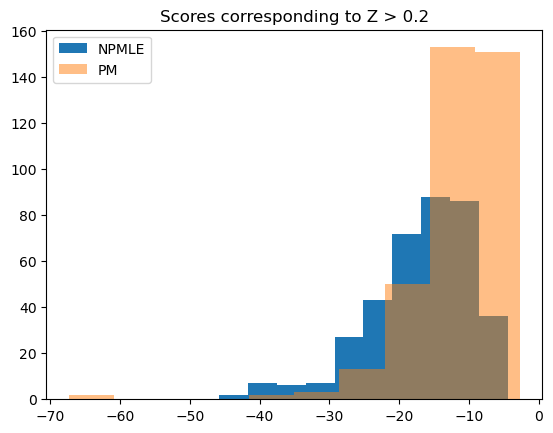

In [34]:
plt.hist(score_NPMLE[(estimates > 0.2)], label="NPMLE")
plt.hist(scores_pm[-1,:][(estimates > 0.2)], label="PM", alpha=0.5)
plt.title("Scores corresponding to Z > 0.2")
plt.legend()
plt.show()

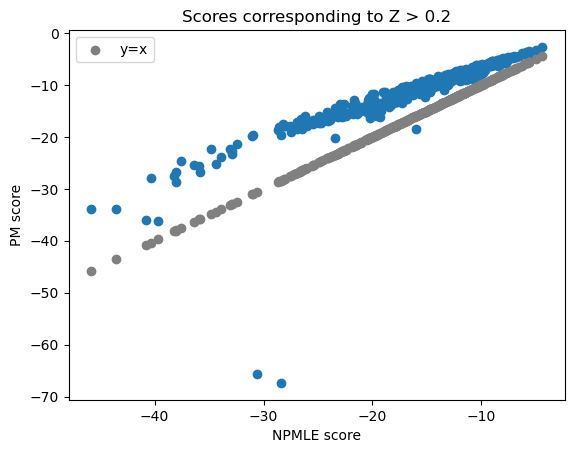

In [46]:
plt.scatter(score_NPMLE[estimates > 0.2], scores_pm[-1,:][estimates > 0.2])
plt.scatter(score_NPMLE[estimates > 0.2],score_NPMLE[estimates > 0.2], color="gray", label="y=x")
plt.title("Scores corresponding to Z > 0.2")
plt.legend()
plt.xlabel("NPMLE score")
plt.ylabel("PM score")
plt.show()

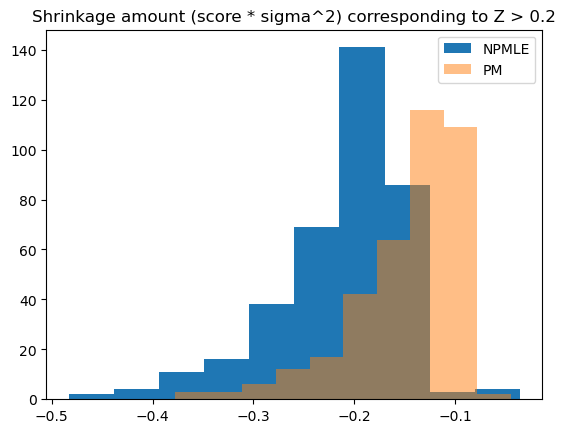

In [35]:
plt.hist(score_NPMLE[estimates > 0.2]*(sigma_np[estimates > 0.2])**2, label="NPMLE")
plt.hist(scores_pm[-1,:][estimates > 0.2] *(sigma_np[estimates > 0.2])**2 , label="PM", alpha=0.5)
plt.title("Shrinkage amount (score * sigma^2) corresponding to Z > 0.2")
plt.legend()
plt.show()

In [72]:
np.mean(scores_pm[-1,:][estimates > 0.2])

-11.844287193340755

In [ ]:
np.mean(score_NPMLE[estimates > 0.2])

-16.94295976924065

In [74]:
np.median(estimates[estimates > 0.2])

0.24578602500000002

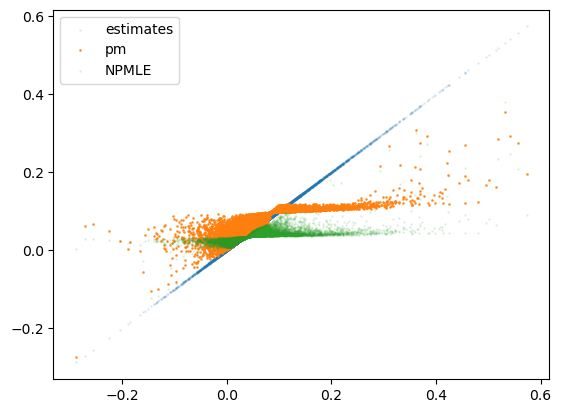

In [62]:

plt.scatter(estimates, estimates, label="estimates", s = 0.8, alpha=0.1)
plt.scatter(estimates, estimates + sigma_np**2 *scores_pm[-1,:], label="pm", s=0.8, alpha=0.8)
plt.scatter(estimates, estimates + sigma_np**2 *score_NPMLE, label="NPMLE", s=0.8, alpha=0.1)

plt.legend()
plt.show()